In [1]:
from mpi4py import MPI
import gmsh
import numpy as np
from scipy.spatial import cKDTree
import pyvista as pv
from dolfinx import plot

# --- before the refinement loop (rank 0 only collects) ---
h_list, L2_list, L2_fem_list, rL2_list, rL2s_fem_list, H1s_list, rH1s_list = [], [], [], [], [], [], []
# L2_fem_list_pf, rL2s_fem_list_pf, H1s_list_pf, rH1s_list_pf = [], [], [], []
# L2_fem_list_lmbd, rL2s_fem_list_lmbd, H1s_list_lmbd, rH1s_list_lmbd = [], [], [], []

# plotter = pv.Plotter(shape=(2, 4), window_size=(2000, 1000))
N_ref = 10

Lx, Ly = 1.0, 1.0
# y_start, y_end = 0.0, 1.0
# x_start, x_end = 0.25, 0.75


In [2]:
from dolfinx import mesh, fem
import ufl
import numpy as np
from dolfinx.io import gmsh as gmshio
from mpi4py import MPI

# ---------------------------------------------------------------------
# 1. Mesh and tags (same mesh as reference)
# ---------------------------------------------------------------------
ref = 4
filename = f"regular_mesh_{ref}.msh"
msh, cell_markers, facet_markers = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=2)[0:3]

tdim = msh.topology.dim  # 2
fdim = tdim - 1          # 1

lc = 1.0 / (2**ref)      # mesh size
h = lc

omega = msh

# ---------------------------------------------------------------------
# 2. Function space (standard CG on the bulk only)
# ---------------------------------------------------------------------
order = 1
V = fem.functionspace(omega, ("Lagrange", order))

# ---------------------------------------------------------------------
# 3. Trial / Test / Solution function
# ---------------------------------------------------------------------
phi = ufl.TestFunction(V)
p = fem.Function(V, name="p")
dp = ufl.TrialFunction(V)

# ---------------------------------------------------------------------
# 4. Coordinates and data
# ---------------------------------------------------------------------
x = ufl.SpatialCoordinate(omega)
# f_m = fem.Constant(omega, 0.0)
f_m = 2*(x[1] - x[1]**2 + x[0] - x[0]**2)
# create function
k_m = fem.Function(V, name="kappa")

def k_callable(x):
    # x is array with shape (gdim, N). compute scalar per point, return shape (1,N)
    vals = 2*(x[0])*x[1]
    return vals[np.newaxis, :]

k_m.interpolate(k_callable)

# kappa = 1.0
# k_m = fem.Constant(omega, kappa)  # bulk permeability

dx = ufl.Measure("dx", domain=omega)

# compute domain bbox to locate sides
coords = omega.geometry.x
xx = coords[:, 0]
yy = coords[:, 1]
xmin, xmax = xx.min(), xx.max()
ymin, ymax = yy.min(), yy.max()

tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# locate boundary facets for bottom (y = ymin) and top (y = ymax)
bottom_facets = mesh.locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymin, atol=tol)
)
top_facets = mesh.locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymax, atol=tol)
)

# create meshtags for those Neumann parts (optional — kept for clarity)
indices = np.concatenate([bottom_facets, top_facets]).astype(np.int32)
values = np.concatenate([
    np.full(bottom_facets.shape, 10, dtype=np.int32),  # bottom tag = 10
    np.full(top_facets.shape,    20, dtype=np.int32),  # top tag    = 20
])
neumann_tags = mesh.meshtags(omega, fdim, indices, values)

# boundary measure (we'll use ds over the whole boundary with conditional g_N)
dsN = ufl.Measure("ds", domain=omega)  # we integrate g_N over the boundary

# Neumann data as conditional on the y coordinate (same as reference)
# g_N = ufl.conditional(
#     ufl.lt(abs(x[1] - ymax), tol),
#     -1.0,                                # top
#     ufl.conditional(
#         ufl.lt(abs(x[1] - ymin), tol),
#         2.0,                             # bottom
#         0.0                              # elsewhere
#     ),
# )

# ---------------------------------------------------------------------
# 5. Weak form (standard Darcy / Poisson form)
# ---------------------------------------------------------------------
a = ufl.inner(k_m * ufl.grad(dp), ufl.grad(phi)) * dx
L = f_m * phi * dx
# L -= g_N * phi * dsN

# Form for assembling (bilinear/trilinear functions expect TrialFunction in a)
A_form = ufl.inner(k_m * ufl.grad(dp), ufl.grad(phi)) * dx
b_form = L

# ---------------------------------------------------------------------
# 6. Dirichlet BCs (left/right like reference)
# ---------------------------------------------------------------------
# locate dofs on each side
left_dofs   = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], xmin, atol=tol))
right_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], xmax, atol=tol))
top_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[1], ymax, atol=tol))
bottom_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[1], ymin, atol=tol))

all_dofs = np.unique(np.concatenate([left_dofs, right_dofs, top_dofs, bottom_dofs]))

p_bc_fun = fem.Function(V)
p_bc_fun.x.array[left_dofs] = 0.0
p_bc_fun.x.array[right_dofs] = 0.0
p_bc_fun.x.array[top_dofs] = 0.0
p_bc_fun.x.array[bottom_dofs] = 0.0

bc = fem.dirichletbc(p_bc_fun, all_dofs)
bcs = [bc]

# ---------------------------------------------------------------------
# 7. Solve linear problem using dolfinx.fem.petsc.LinearProblem
# ---------------------------------------------------------------------
from dolfinx.fem import petsc

linear_problem = petsc.LinearProblem(
    a=A_form,
    L=b_form,
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "ksp_error_if_not_converged": True,
    },
    petsc_options_prefix="pmix_"
)

p_sol = linear_problem.solve()
p_sol.name = "pressure"

# optionally copy into p Function if you prefer
p.x.array[:] = p_sol.x.array[:]

# ---------------------------------------------------------------------
# 8. Diagnostics
# ---------------------------------------------------------------------
print("DOFs in V:", V.dofmap.index_map.size_global)


Info    : Reading 'regular_mesh_4.msh'...
Info    : 2337 entities
Info    : 289 nodes
Info    : 2337 elements
Info    : Done reading 'regular_mesh_4.msh'
DOFs in V: 289


In [3]:
from dolfinx.io import XDMFFile
import pathlib

outdir = pathlib.Path("result_test_lcg_regular_ex1_2013_2")
outdir.mkdir(exist_ok=True)

from dolfinx.io import XDMFFile

# ------------------------------
# 1) Save bulk field p_m on Ω
# ------------------------------
omega_file = outdir / "p_h.xdmf"
with XDMFFile(omega.comm, str(omega_file), "w") as xdmf:
    xdmf.write_mesh(omega)
    xdmf.write_function(p_sol)

In [4]:
p_sol.x.array

array([0.        , 0.        , 0.        , 0.03336589, 0.        ,
       0.        , 0.04459635, 0.04459635, 0.        , 0.        ,
       0.03336589, 0.05957031, 0.03336589, 0.        , 0.        ,
       0.        , 0.04459635, 0.04459635, 0.        , 0.        ,
       0.03336589, 0.        , 0.        , 0.        , 0.        ])

In [5]:
dof_coords = V.tabulate_dof_coordinates()
dof_coords


array([[-1.38777878e-17,  7.50000000e-01,  0.00000000e+00],
       [ 2.50000000e-01,  1.00000000e+00,  0.00000000e+00],
       [-1.38777878e-17,  1.00000000e+00,  0.00000000e+00],
       [ 2.50000000e-01,  7.50000000e-01,  0.00000000e+00],
       [-1.38777878e-17,  5.00000000e-01,  0.00000000e+00],
       [ 5.00000000e-01,  1.00000000e+00,  0.00000000e+00],
       [ 2.50000000e-01,  5.00000000e-01,  0.00000000e+00],
       [ 5.00000000e-01,  7.50000000e-01,  0.00000000e+00],
       [-1.38777878e-17,  2.50000000e-01,  0.00000000e+00],
       [ 7.50000000e-01,  1.00000000e+00,  0.00000000e+00],
       [ 2.50000000e-01,  2.50000000e-01,  0.00000000e+00],
       [ 5.00000000e-01,  5.00000000e-01,  0.00000000e+00],
       [ 7.50000000e-01,  7.50000000e-01,  0.00000000e+00],
       [ 5.38557018e-18,  5.38557018e-18,  0.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 2.50000000e-01,  5.38557018e-18,  0.00000000e+00],
       [ 5.00000000e-01,  2.50000000e-01

In [5]:
omega.geometry.x

array([[0. , 0.5, 0. ],
       [0.5, 1. , 0. ],
       [0. , 1. , 0. ],
       [0.5, 0.5, 0. ],
       [0. , 0. , 0. ],
       [1. , 1. , 0. ],
       [0.5, 0. , 0. ],
       [1. , 0.5, 0. ],
       [1. , 0. , 0. ]])

In [4]:
# -------------------------
# Utilities
# -------------------------
def cell_centroid(cell_coords):
    """Return centroid (2,) of triangle cell_coords shape (3,2)."""
    return np.mean(cell_coords, axis=0)

def edge_midpoint(a, b):
    return 0.5 * (a + b)

def edge_length(a, b):
    return np.linalg.norm(a - b)

def outward_normal_of_edge_in_cell(a, b, cell_centroid):
    """
    Return unit normal vector (2,) that points outward from cell across edge (a->b).
    For a triangle cell, take tangent t = b-a, normal = [t_y, -t_x] (or rotated).
    Determine sign by checking pointing away from centroid.
    """
    t = b - a
    # candidate normals (two directions)
    n1 = np.array([ t[1], -t[0] ])
    n2 = -n1
    # pick normal that points away from centroid
    midpoint = 0.5*(a + b)
    vec_centroid_to_mid = midpoint - cell_centroid
    # if dot(n1, centroid->midpoint) < 0, then n1 points outward (away from centroid)
    if np.dot(n1, vec_centroid_to_mid) < 0:
        chosen = n1
    else:
        chosen = n2
    norm = np.linalg.norm(chosen)
    if norm == 0:
        return chosen
    return chosen / norm

def outward_normal_from_C_to_t(centroid, midpoint, coords, i):
    """
    Compute unit normal on interior segment (centroid -> midpoint)
    pointing from central polygon C into control volume t_i.

    Parameters
    ----------
    centroid : (2,) ndarray
        Centroid of triangle
    midpoint : (2,) ndarray
        Midpoint of an edge adjacent to vertex i
    coords : (3,2) ndarray
        Coordinates of triangle vertices [v0, v1, v2]
    i : int
        Vertex index (0,1,2) corresponding to control volume t_i

    Returns
    -------
    n : (2,) ndarray
        Unit normal pointing from C into t_i
    """

    # segment tangent
    t = midpoint - centroid

    # candidate normals
    n1 = np.array([ t[1], -t[0] ])
    n2 = -n1

    # mid point of the segment
    seg_mid = 0.5 * (centroid + midpoint)

    # direction toward vertex v_i
    v_i = coords[i]
    dir_to_vertex = v_i - seg_mid

    # choose correct orientation
    if np.dot(n1, dir_to_vertex) < 0:
        n = n1
    else:
        n = n2

    # normalize
    norm = np.linalg.norm(n)
    if norm < 1e-14:
        raise RuntimeError("Degenerate normal in outward_normal_from_C_to_t")

    return n / norm

def _edge_midpoints(omega):
    """
    Return array of shape (num_edges, gdim) with midpoint coordinates for each mesh edge.
    Also returns the mapping edges -> (vertex_i, vertex_j) as an (num_edges, 2) int array.
    """
    tdim = omega.topology.dim
    # ensure connectivity exists
    omega.topology.create_connectivity(0, tdim - 1)     # vertices -> edges
    v2e = omega.topology.connectivity(0, tdim - 1)
    # num_edges = len(v2e)  # number of edges in topology (works in dolfinx)
    # gather endpoints for each edge: we invert the mapping vertices->edges
    # build an array edges -> list of vertices by scanning v2e.links for each vertex
    # A simpler approach: use edge->vertex connectivity if available (1 -> 0)
    try:
        e2v = omega.topology.connectivity(tdim - 1, 0)  # edges -> vertices
    except Exception:
        # try to create vertex->edge then invert manually
        raise RuntimeError("mesh topology missing edges->vertices connectivity")
    # e2v.links(edge) returns the two vertex indices for that edge
    n_edges = len(e2v)
    gdim = omega.geometry.x.shape[1]
    mids = np.empty((n_edges, gdim), dtype=float)
    endpoints = np.empty((n_edges, 2), dtype=int)
    for e in range(n_edges):
        vs = e2v.links(e)
        if len(vs) != 2:
            raise RuntimeError(f"edge {e} does not have 2 endpoints (len={len(vs)})")
        v0, v1 = int(vs[0]), int(vs[1])
        endpoints[e, 0] = v0
        endpoints[e, 1] = v1
        x0 = omega.geometry.x[v0]
        x1 = omega.geometry.x[v1]
        mids[e, :] = 0.5*(x0 + x1)
    return mids, endpoints
import math
def find_edge_by_coords_midpoint(omega, a_coord, b_coord, tol=None):
    """
    Given mesh `omega` and two coordinates a_coord, b_coord (which may be vertices,
    midpoints, or generally points on the same geometric edge), find matching mesh edge.

    Returns: edge_index (int), is_boundary (bool), cell_ids (list of ints), neighbor (int or None)

    Raises ValueError if no matching edge found within tol.
    """
    a = np.asarray(a_coord, dtype=float)
    b = np.asarray(b_coord, dtype=float)
    if a.shape != b.shape:
        raise ValueError("a_coord and b_coord must have same dimension")

    m = 0.5*(a + b)  # input midpoint

    # build mesh edge midpoints and endpoints
    omega.topology.create_connectivity(0, omega.topology.dim - 1)
    omega.topology.create_connectivity(omega.topology.dim - 1, omega.topology.dim)
    omega.topology.create_connectivity(omega.topology.dim - 1, 0)  # edges -> vertices
    mids, endpoints = _edge_midpoints(omega)   # mids shape (n_edges, gdim)

    # compute distances from m to all mids
    d2 = np.sum((mids[:,0:2] - m.reshape(1,-1))**2, axis=1)
    e_min = int(np.argmin(d2))
    min_dist = math.sqrt(float(d2[e_min]))

    # choose tolerance if not provided:
    # use half the length of that candidate edge (robust)
    v0, v1 = endpoints[e_min]
    x0 = omega.geometry.x[v0]
    x1 = omega.geometry.x[v1]
    edge_len = math.sqrt(np.sum((x1 - x0)**2))
    default_tol = 0.5 * edge_len + 1e-12  # allow up to half-length (should be enough)
    if tol is None:
        tol_use = default_tol
    else:
        tol_use = float(tol)

    if min_dist > tol_use:
        raise ValueError(f"No mesh edge found near midpoint {m}; closest distance {min_dist:.3e} > tol {tol_use:.3e}")

    # we have candidate edge index e_min
    edge = e_min

    # find adjacent cells
    e2c = omega.topology.connectivity(omega.topology.dim - 1, omega.topology.dim)
    cells = e2c.links(edge).astype(int)

    if len(cells) == 1:
        return True, [int(cells[0])]
    elif len(cells) == 2:
        # return neighbor as the second one (caller can interpret or choose relative to tau)
        return False, [int(cells[0]), int(cells[1])]
    else:
        raise RuntimeError("Invalid mesh topology: edge attached to >2 cells")

In [ ]:
def f_callable(x):
    return 2*(x[1] - x[1]**2 + x[0] - x[0]**2)

f = fem.Function(V)
f.interpolate(f_callable)

# f = fem.Function(V)
# f.interpolate(f_m)
# def postprocess_local_conservative_flux(mesh, V, u_h, kappa, f=None, bcs=None):
"""
mesh  : dolfinx mesh
V     : FunctionSpace (P1) of u_h
u_h   : dolfinx.Function with CG solution (P1)
kappa : float or dolfinx.Function (can be evaluated at points)
f     : optional RHS source dolfinx.Function (or None)
bcs   : optional boundary conditions (not directly used here, but useful info)
Returns:
    local_fluxes : dict mapping cell index -> dict with keys:
        'coeffs' : local nodal values of \tilde u on this element (3,)
        'q'      : flux vector (2,) on this element (constant per element)
        'cell'   : cell index
"""
# Access mesh geometry
tdim = omega.topology.dim
assert tdim == 2, "This implementation is for triangular 2D meshes"
assert V.ufl_element().degree == 1, "Only P1 supported in this implementation"

# Gather coordinates and connectivity
omega_geometry = omega.geometry.x[:,0:2]  # global array of vertex coords
# Build cell->vertex mapping (fast access)
# Using dolfinx.Cell to get connectivity is more robust, but below uses mesh.topology
cells = omega.topology.connectivity(0, tdim)  # vertices -> cells
# Instead get cell->vertex mapping via mesh.topology.index_map?
# Simpler: use mesh.geometry.x with mesh.topology.connectivity(tdim, 0)
ctv = omega.topology.connectivity(tdim, 0)
if ctv is None:
    omega.topology.create_connectivity(tdim, 0)
    ctv = omega.topology.connectivity(tdim, 0)
# ctv.array() gives flattened vertex indices -> need per-cell view
# There's a helper to get cell entity indices
num_cells = omega.topology.index_map(tdim).size_local  # per-rank local count
# We'll iterate over local cells only
local_cells = np.arange(num_cells, dtype=np.int32)

# For evaluating u_h and kappa, we can use u_h.x.array if needed.
# But easier: create a point evaluation lambda to get value at a point
from dolfinx.fem import Function
u_func = p_sol

# Precompute reference basis grads in physical coords per cell:
# For P1, grad phi_j is constant on cell; we can compute using inverse Jacobian
# For each local cell:
local_fluxes = {}
V_dofmap = V.dofmap.index_map.local_range  # not directly used; we'll query dofs per cell

# Get dof indices per cell
# Using dolfinx.fem.locate_dofs_topological is one option, but below we get cell_dofs
dofmap = V.dofmap
# iterate over local cells using mesh.topology.connectivity(tdim, 0)
# cell_to_vertices = ctv.links().reshape((-1, 3))  # might be shape (num_cells, 3)
# cell_to_vertices = np.array([ctv.links(c) for c in range(ctv.num_nodes)])

# But to avoid uncertain reshape semantics, use mesh.topology.connectivity(tdim, 0).entities
# Simpler robust approach: use dolfinx.mesh.cells() to get local cells vertex indices
try:
    from dolfinx.mesh import cells as dolfinx_cells
    local_cell_vertices = dolfinx_cells(mesh)
except Exception:
    # fallback: create by slicing connectivity
    # arr = ctv.array
    # local_cell_vertices = arr.reshape((-1, 3))
    local_cell_vertices = np.array([ctv.links(c) for c in range(ctv.num_nodes)])

# Helper to evaluate a scalar Function (or float) at a point (x,y)
from dolfinx import geometry
def eval_scalar_at_point(u, point):
    """
    Evaluate a scalar dolfinx.fem.Function `u` at a single physical point.

    Parameters
    ----------
    u : dolfinx.fem.Function or float/int
    point : sequence of length mesh.dim

    Returns
    -------
    float
    """
    # allow plain scalars
    if isinstance(u, (float, int, np.floating, np.integer, np.float64)):
        return float(u)
    point = np.asarray(point)
    if point.ndim == 1:
        point = point.reshape(-1, 1)
    V = u.function_space
    mesh = V.mesh
    tdim = mesh.topology.dim
    gdim = mesh.geometry.dim

    # X = np.asarray(point, dtype=np.float64).reshape(1, -1)  # shape (1, dim)
    _gdim, N = point.shape
    if _gdim != gdim:
        raise ValueError(f"Point array has gdim={_gdim}, expected {gdim}")

    # dolfinx expects 3D coordinates; pad in 2D
    if gdim == 2:
        X = np.column_stack([point.T, np.zeros(N, dtype=np.float64)])  # (N, 3)
    elif gdim == 3:
        X = point.T.copy()                                             # (N, 3)
    else:
        raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

    # 1) bounding-box tree + collision test
    bbt = geometry.bb_tree(mesh, tdim)
    cands = geometry.compute_collisions_points(bbt, X)
    hits = geometry.compute_colliding_cells(mesh, cands, X)

    # pick first hit if any
    cell = -1
    links = hits.links(0)
    if len(links) > 0:
        cell = int(links[0])

    # 2) fallback: nearest entity (robust for boundary points / tiny roundoff)
    if cell == -1:
        mid_tree = geometry.create_midpoint_tree(
            mesh, tdim,
            np.arange(mesh.topology.index_map(tdim).size_local, dtype=np.int32)
        )
        nearest = geometry.compute_closest_entity(bbt, mid_tree, mesh, X)
        cell = int(nearest[0])

    # 3) Evaluate using dolfinx Function.eval
    # Try the common signature that returns an array: val = u.eval(X, cells)
    try:
        vals = np.asarray(u.eval(X, np.array([cell], dtype=np.int32))).ravel()
        return float(vals[0])
    except Exception:
        # Alternative signature: u.eval(values_buffer, X, cell)
        # Prepare buffer of correct size (value_size per point)
        vsize = getattr(u, "value_size", 1)
        buf = np.zeros((vsize, 1), dtype=np.float64) if vsize > 1 else np.zeros(1, dtype=np.float64)
        try:
            # note: some dolfinx versions expect (buf, X, cell)
            u.eval(buf, X, cell)
            return float(np.asarray(buf).ravel()[0])
        except Exception as e:
            raise RuntimeError(f"Failed to evaluate Function at point {point}: {e}")
# Gradients of reference P1 basis on reference triangle: (constant)
# On reference triangle with vertices (0,0),(1,0),(0,1): grads are:
# grad phi0 = (-1, -1), grad phi1 = (1, 0), grad phi2 = (0, 1)
# ref_grads = np.array([[-1.0, -1.0],
#                         [ 1.0,  0.0],
#                         [ 0.0,  1.0]])

def polygon_volume(vertices, heights, triangles):
    """
    vertices  : list of 2D points [(x,y), ...] length 4
    heights   : list of heights [h0, h1, h2, h3]
    triangles : list of triangles [[i,j,k], [i,j,k]]
    """

    def triangle_area(i, j, k):
        x1, y1 = vertices[i]
        x2, y2 = vertices[j]
        x3, y3 = vertices[k]
        return 0.5 * abs(
            (x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1)
        )

    volume = 0.0
    for i, j, k in triangles:
        A = triangle_area(i, j, k)
        h_avg = (heights[i] + heights[j] + heights[k]) / 3.0
        volume += A * h_avg

    return volume

ref_grads = np.array([[-1.0, -1.0],[1.0, 0.0],[0.0, 1.0]])
elem_grad_u = {}
elem_area = {}
# elem_kappa_cent = {}
from tqdm import tqdm
for local_cell_idx, verts in enumerate(local_cell_vertices):
    coords = omega_geometry[verts]
    J = np.column_stack((coords[1] - coords[0], coords[2] - coords[0]))
    detJ = np.linalg.det(J)
    area = 0.5 * abs(detJ)
    # invJ_T = np.linalg.inv(J).T
    invJ = np.linalg.inv(J)
    # phys_grads = (ref_grads @ invJ_T)
    phys_grads = ref_grads @ invJ
    try:
        cell_dofs = dofmap.cell_dofs(local_cell_idx)
    except Exception:
        cell_dofs = verts
    u_vals = np.array([p_sol.x.array[int(d)] for d in cell_dofs])
    grad_u = np.sum(u_vals[:, None] * phys_grads, axis=0)
    elem_grad_u[int(local_cell_idx)] = grad_u
    elem_area[int(local_cell_idx)] = area
    centroid = cell_centroid(coords)
    # elem_kappa_cent[int(local_cell_idx)] = eval_scalar_at_point(k_m, centroid)

coef_glob = {i: [] for i in range(len(omega.geometry.x))}
# Iterate local cells
for local_cell_idx, cell_verts in enumerate(tqdm(local_cell_vertices)):
    # cell_verts are global vertex indices
    coords = omega_geometry[cell_verts]  # shape (3,2)
    centroid = cell_centroid(coords)

    # compute Jacobian matrix J = [x1-x0, x2-x0] (2x2), mapping from reference to physical
    J = np.column_stack((coords[1] - coords[0], coords[2] - coords[0]))  # 2x2
    detJ = np.linalg.det(J)
    if abs(detJ) < 1e-15:
        raise RuntimeError("Degenerate cell detected")
    invJ = np.linalg.inv(J)  # invert and transpose to map ref grads -> phys grads

    # physical gradients of P1 bases (3,2)
    phys_grads = (ref_grads @ invJ)  # shape (3,2)

    # nodal global dof indices for this cell
    # dolfinx provides dofmap.cell_dofs
    try:
        cell_dofs = dofmap.cell_dofs(local_cell_idx)
    except Exception:
        # fallback: compute mapping by matching coordinates - not robust
        raise RuntimeError("Could not obtain cell dofs from dofmap. Adapt this code to your dolfinx version.")

    # evaluate u_h gradient on this cell: for P1, u_h gradient = sum(u_i * grad_phi_i)
    u_vals = np.array([u_func.x.array[d] for d in cell_dofs])  # nodal values on this cell
    grad_u = np.sum(u_vals[:, None] * phys_grads, axis=0)  # (2,)

    # Build local matrix B (3x3) and RHS rhs (3,)
    B = np.zeros((3, 3), dtype=float)
    rhs = np.zeros(3, dtype=float)

    # contributions:  a_tau(u_h, phi_i) = int_tau kappa * grad_u_h . grad_phi_i dx
    # For P1, integrand is constant in cell, integral = kappa_at_centroid * (grad_u . grad_phi_i) * |tau|
    area = 0.5 * abs(detJ)
    # kappa_cent = eval_scalar_at_point(k_m, centroid)
    k_at_vertices = [eval_scalar_at_point(k_m, cc) for cc in coords]
    a_tau = []
    for i in range(3):
        a_tau.append(np.sum(k_at_vertices)/3 * np.dot(grad_u, phys_grads[i]) * area)
        rhs[i] += a_tau[i]

    # also include source f term if given: ell_tau(I_tau phi_i - phi_i)
    # For P1, I_tau(phi_i) on t_i equals 1 on t_i, and 0 elsewhere. The difference I_tau(phi_i)-phi_i is
    # piecewise: on the two boundary half-edges the integrals are taken into account in e_tau below.
    if f is not None:
        # compute integral of f over t_i (control volume). For P1, control volume area for each vertex is area/3 (if centroid partition)
        # With centroid-midpoint partition, each t_i area = area/3
        int_f_t = []
        l_phi = []
        volume_direct = []
        for i in range(3):
            # evaluate f at centroid of t_i approx: approximate by centroid of t_i polygon -> we take triangle centroid
            # More accurate: compute centroid of quadrant (v_i, midpoint_i,i+1, centroid, midpoint_i,i-1) but area is area/3
            vv = [coords[i], edge_midpoint(coords[i], coords[(i+1)%3]), edge_midpoint(coords[i], coords[(i-1)%3]), centroid]
            hf = [eval_scalar_at_point(f, v_pol) for v_pol in vv]
            hh = [0, 1/2, 1/2, 2/3]
            hff = [hf[v_pol]*hh[v_pol] for v_pol in range(4)]

            # approach 2
            int_f_t.append(polygon_volume(vv, hf, [[0,1,2],[1,2,3]]))
            l_phi.append(hf[0]*area/3)
            volume_direct.append(polygon_volume(vv, hff, [[0,1,2],[1,2,3]]))
            rhs[i] += int_f_t[i] - l_phi[i]

            # t_i_centroid = (coords[i] + centroid + edge_midpoint(coords[i], coords[(i+1)%3]) + edge_midpoint(coords[i], coords[(i-1)%3]))/4.0
            # f_val = eval_scalar_at_point(f, t_i_centroid)
            # rhs[i] += f_val * (area / 3.0) * 0.5 / 2

    # Now assemble B matrix from boundary half-edges:
    # compute centroid and edge midpoints (coords array shape (3,2))
    centroid = cell_centroid(coords)
    edge_midpoints = [0.5*(coords[i] + coords[(i+1)%3]) for i in range(3)]

    # internal segments: for vertex i the two segments are
    #   sA: centroid -> midpoint(edge i,i+1)
    #   sB: centroid -> midpoint(edge i-1,i)
    for i in range(3): #i for eta or w
        midA = edge_midpoints[i]          # midpoint of edge (i, i+1)
        midB = edge_midpoints[(i-1)%3]    # midpoint of edge (i-1, i)
        # segment sA: centroid -> midA
        sA_midpoint = 0.5*(centroid + midA)
        sA_len = np.linalg.norm(midA - centroid)
        nA = outward_normal_from_C_to_t(centroid, midA, coords, i)  # unit normal pointing into t_i
        # kappa_A = eval_scalar_at_point(k_m, sA_midpoint)
        k_at_tips = [eval_scalar_at_point(k_m, centroid), eval_scalar_at_point(k_m, midA)]
        for j in range(3):
            B[i, j] += - np.sum(k_at_tips)/2 * np.dot(phys_grads[j], nA) * sA_len

        # segment sB: centroid -> midB
        sB_midpoint = 0.5*(centroid + midB)
        sB_len = np.linalg.norm(midB - centroid)
        nB = outward_normal_from_C_to_t(centroid, midB, coords, i)
        # kappa_B = eval_scalar_at_point(kappa, sB_midpoint)
        k_at_tips = [eval_scalar_at_point(k_m, centroid), eval_scalar_at_point(k_m, midB)]
        for j in range(3):
            B[i, j] += - np.sum(k_at_tips)/2 * np.dot(phys_grads[j], nB) * sB_len


        # e_tau term: boundary flux (kappa * grad u_h . n) * (I_tau phi_i - phi_i) integrated on boundary half-edges
        # We'll approximate by midpoint rule:
        # On half-edge near node i, I_tau(phi_i)=1 while phi_i varies from 1 at vertex to 0 at midpoint.
        # So (I_tau(phi_i) - phi_i) at midpoint ~ (1 - phi_i(midpoint)) = 1 - 0.5 = 0.5 (since phi_i at edge midpoint = 0.5)
        # Thus approximate integrand value = (kappa * grad_u . n) * 0.5
        # For other half-edge near other node j, the value for phi_i is 0 at midpoint, and I_tau is 0 or 1 accordingly.
        # This is an approximation consistent with midpoint evaluation for P1.
        # More exact formulas can be derived; we keep midpoint approx here.
        # contribution to rhs: add (kappa * grad_u . n) * (I_tau - phi_i) * half_len
        # for edge A (half near i)
    e_tau = [0 for i in range(3)]
    e_tau_part1 = [0 for _ in range(3)]
    e_tau_part2 = [0 for _ in range(3)]
    for i in range(3):
        # edges adjacent to vertex i: (i, i_next) and (i_prev, i)
        i_next = (i + 1) % 3
        i_prev = (i - 1) % 3

        # edge A: between vertex i and i_next
        aA = coords[i]
        bA = coords[i_next]
        midpointA = edge_midpoint(aA, bA)
        # half-edge length is half edge length
        half_len_A = 0.5 * edge_length(aA, bA)
        phi_i_mid_A = 0.5  # phi_i at midpoint of edge (i, i_next) equals 0.5 if i is one endpoint
        Itau_minus_phi_mid_A = 1.0 - phi_i_mid_A
        nA = outward_normal_from_C_to_t(aA, bA, coords, i)
        if np.dot(nA, (centroid - midpointA)) > 0:
            nA = -nA
        # flux_uA = kappa_A * np.dot(grad_u, nA)
        # q_uA = kappa_A * grad_u
        k_at_tips = [eval_scalar_at_point(k_m, aA), eval_scalar_at_point(k_m, midpointA)]
        q_uA = [k_at_tips[0]*grad_u, k_at_tips[1]*grad_u]
        flux_uA = [np.dot(q_uA_i, nA) for q_uA_i in q_uA]
        is_boundary, cell_of_edges = find_edge_by_coords_midpoint(omega, aA, bA)
        if is_boundary:
            q_avgA = q_uA
            flux_avg = np.sum(flux_uA)/2
        else:
            nbr_idx = np.where(np.array(cell_of_edges) != local_cell_idx)[0][0]
            nbr = cell_of_edges[nbr_idx]
            # kappa_nbr = elem_kappa_cent[nbr]
            grad_u_nbr = elem_grad_u[nbr]
            q_nbr = [k_at_tips[0]*grad_u_nbr, k_at_tips[1]*grad_u_nbr]
            q_avgA = [(q_uA[0] + q_nbr[0])/2, (q_uA[1] + q_nbr[1])/2]
            flux_avg = [np.dot(q_avgA_i, nA) for q_avgA_i in q_avgA]     # neighbor uses same n_edge orientation
            flux_avg = np.sum(flux_avg)/2
        e_tau[i] += flux_avg * Itau_minus_phi_mid_A * half_len_A / 2
        e_tau_part1[i] += flux_avg*half_len_A
        
        # rhs[i] += 

        # for edge B (half near i)
        # edge B: between vertex i_prev and i
        aB = coords[i_prev]
        bB = coords[i]
        midpointB = edge_midpoint(aB, bB)
        half_len_B = 0.5 * edge_length(aB, bB)

        phi_i_mid_B = 0.5
        Itau_minus_phi_mid_B = 1.0 - phi_i_mid_B
        nB = outward_normal_from_C_to_t(aB, bB, coords, i)
        if np.dot(nB, (centroid - midpointB)) > 0:
            nB = -nB
        k_at_tips = [eval_scalar_at_point(k_m, aB), eval_scalar_at_point(k_m, midpointB)]
        q_uB = [k_at_tips[0]*grad_u, k_at_tips[1]*grad_u]
        flux_uB = [np.dot(q_uB_i, nB) for q_uB_i in q_uB]
        is_boundary, cell_of_edges = find_edge_by_coords_midpoint(omega, aB, bB)
        if is_boundary:
            q_avgB = q_uB
            flux_avg = np.sum(flux_uB)/2
        else:
            nbr_idx = np.where(np.array(cell_of_edges) != local_cell_idx)[0][0]
            nbr = cell_of_edges[nbr_idx]
            # kappa_nbr = elem_kappa_cent[nbr]
            grad_u_nbr = elem_grad_u[nbr]
            q_nbr = [k_at_tips[0]*grad_u_nbr, k_at_tips[1]*grad_u_nbr]
            q_avgB = [(q_uB[0] + q_nbr[0])/2, (q_uB[1] + q_nbr[1])/2]
            flux_avg = [np.dot(q_avgB_i, nB) for q_avgB_i in q_avgB]     # neighbor uses same n_edge orientation
            flux_avg = np.sum(flux_avg)/2
        e_tau[i] += flux_avg * Itau_minus_phi_mid_B * half_len_B / 2
        e_tau_part1[i] += flux_avg*half_len_B
        
        
        e_tau_part2[i] += np.dot(q_avgA[0], nA)*half_len_A + np.dot(q_avgB[1], nB)*half_len_B #lenA / 2
        # rhs[i] += e_tau[i]
        rhs[i] += e_tau_part1[i] - e_tau_part2[i]

    # At this point we have B matrix and rhs vector. Solve local system B c = rhs for c = nodal values of tilde u
    # If any local DOF is Dirichlet (boundary condition), enforce it by removing row/col or by setting large diag.
    # Here we will check whether any of the cell nodes are Dirichlet via provided bcs (if any) and enforce strongly.
    # For simplicity: if node is Dirichlet, set that coefficient to u_h nodal value and reduce system.
    fixed = {}
    if bcs is not None:
        # bcs is list of Dirichlet BC objects; we can check dof indices
        # Build set of fixed global dofs from bcs
        fixed_global = set()
        for bc in bcs:
            # bc.dof_indices() or bc.get_values? Variation across dolfinx versions
            try:
                bc_dofs = bc.dof_indices()
            except Exception:
                try:
                    bc_dofs = bc.dofs
                except Exception:
                    bc_dofs = []
            for gd in bc_dofs[0]:
                fixed_global.add(int(gd))
        # map cell_dofs -> local indices
        for local_i, gd in enumerate(cell_dofs):
            if int(gd) in fixed_global:
                fixed[local_i] = float(u_func.x.array[int(gd)])  # Dirichlet value

    if len(fixed) > 0:
        # reduce system (eliminate fixed DOFs)
        free_idx = [i for i in range(3) if i not in fixed]
        if len(free_idx) == 0:
            # all fixed, nothing to solve
            coeffs = np.array([fixed[i] for i in range(3)], dtype=float)
        else:
            Bff = B[np.ix_(free_idx, free_idx)]
            rhsf = rhs[free_idx].copy()
            # subtract fixed contributions
            for li, val in fixed.items():
                rhsf -= B[np.ix_(free_idx, [li])].ravel() * val
            # sol_free = np.linalg.solve(Bff, rhsf)
            sol_free, residuals, rank, s = np.linalg.lstsq(Bff, rhsf, rcond=None)
            coeffs = np.zeros(3, dtype=float)
            for idx, li in enumerate(free_idx):
                coeffs[li] = sol_free[idx]
            for li, val in fixed.items():
                coeffs[li] = val
        for local_i, gd in enumerate(cell_dofs):
            coef_glob[gd].append(coeffs[local_i])
    else:
        # direct solve
        # try:
        #     coeffs = np.linalg.solve(B, rhs)
        #     print("direct solve")
        #     # for local_i, gd in enumerate(cell_dofs):
        #     #     coef_glob[gd].append(coeffs[local_i])
        # except:
        #     pass
        # map cell_dofs -> local indices
        local_i_select = []
        gd_select = []
        for local_i, gd in enumerate(cell_dofs):
            if len(coef_glob[gd]) != 0:
                local_i_select.append(local_i)
                gd_select.append(gd)
        fixed[local_i_select[1]] = float(coef_glob[gd_select[1]][-1])
                # break
                
        if len(fixed) > 0:
            # reduce system (eliminate fixed DOFs)
            free_idx = [i for i in range(3) if i not in fixed]
            if len(free_idx) == 0:
                # all fixed, nothing to solve
                coeffs = np.array([fixed[i] for i in range(3)], dtype=float)
            else:
                Bff = B[np.ix_(free_idx, free_idx)]
                rhsf = rhs[free_idx].copy()
                # subtract fixed contributions
                for li, val in fixed.items():
                    rhsf -= B[np.ix_(free_idx, [li])].ravel() * val
                # sol_free = np.linalg.solve(Bff, rhsf)
                sol_free, residuals, rank, s = np.linalg.lstsq(Bff, rhsf, rcond=None)
                coeffs = np.zeros(3, dtype=float)
                for idx, li in enumerate(free_idx):
                    coeffs[li] = sol_free[idx]
                for li, val in fixed.items():
                    coeffs[li] = val
            for local_i, gd in enumerate(cell_dofs):
                coef_glob[gd].append(coeffs[local_i])
        else:
            coeffs = np.linalg.solve(B, rhs)
            for local_i, gd in enumerate(cell_dofs):
                coef_glob[gd].append(coeffs[local_i])
            print("element index: ", local_cell_idx, " is using direct solver.")
        # coeffs, residuals, rank, s = np.linalg.lstsq(B, rhs, rcond=None)

    # compute local flux q = -kappa * sum_j coeff_j * grad_phi_j (constant per cell)
    # evaluate kappa at centroid for flux
    # kappa_centroid = eval_scalar_at_point(k_m, centroid)
    q = np.sum(coeffs[:, None] * phys_grads, axis=0)  # (2,)

    # store results
    local_fluxes[int(local_cell_idx)] = {
        "coeffs": coeffs,
        "grad": q,
        "cell_vertices": cell_verts,
        "cell_coords": coords
    }

100%|██████████| 512/512 [00:32<00:00, 15.80it/s]


In [28]:
eval_scalar_at_point(k_m, sA_midpoint)

1.7916666666666665

In [35]:
grad_u = elem_grad_u[int(19)]
kappa_cent = elem_kappa_cent[int(19)]
q_CG = - kappa_cent * grad_u
q_CG

array([-3., -0.])

In [40]:
omega.geometry.x

array([[0.  , 0.75, 0.  ],
       [0.25, 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.25, 0.75, 0.  ],
       [0.  , 0.5 , 0.  ],
       [0.5 , 1.  , 0.  ],
       [0.25, 0.5 , 0.  ],
       [0.5 , 0.75, 0.  ],
       [0.  , 0.25, 0.  ],
       [0.75, 1.  , 0.  ],
       [0.25, 0.25, 0.  ],
       [0.5 , 0.5 , 0.  ],
       [0.75, 0.75, 0.  ],
       [0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.  ],
       [0.25, 0.  , 0.  ],
       [0.5 , 0.25, 0.  ],
       [0.75, 0.5 , 0.  ],
       [1.  , 0.75, 0.  ],
       [0.5 , 0.  , 0.  ],
       [0.75, 0.25, 0.  ],
       [1.  , 0.5 , 0.  ],
       [0.75, 0.  , 0.  ],
       [1.  , 0.25, 0.  ],
       [1.  , 0.  , 0.  ]])

  0%|          | 0/289 [00:00<?, ?it/s]

100%|██████████| 289/289 [00:06<00:00, 43.55it/s]


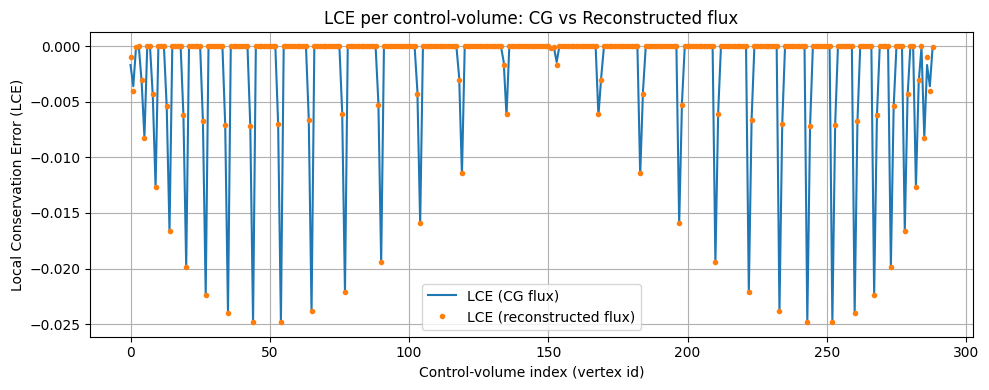

CG LCE stats: {'min': -0.024895736531308835, 'max': 1.7238891868794678e-05, 'L1_mean_abs': 0.0022998275915520976, 'L2_rms': 0.00619114916051674}
Reconstructed LCE stats: {'min': -0.024816293156013, 'max': -1.0172526041480473e-05, 'L1_mean_abs': 0.0022977941176470593, 'L2_rms': 0.006171220343146235}


In [8]:
import matplotlib.pyplot as plt
# geometry + local cell vertices
# geometry = mesh.geometry.x.copy()
# local_cell_vertices = dolfinx_cells(mesh)
num_local_cells = local_cell_vertices.shape[0]

# map vertex -> adjacent local cells
vertex_to_cells = {}
for local_cell_idx, verts in enumerate(local_cell_vertices):
    for v in verts:
        vertex_to_cells.setdefault(int(v), []).append(int(local_cell_idx))

# compute element-wise gradients (P1)
dofmap = V.dofmap

# compute LCEs per vertex (control-volume)
vertex_ids = sorted(list(vertex_to_cells.keys()))
LCE_CG = []
LCE_rec = []
indices = []

for vid in tqdm(vertex_ids):
    flux_sum_CG = 0.0
    flux_sum_rec = 0.0
    source_sum = 0.0
    adjacent_cells = vertex_to_cells[vid]
    vertex_coord = omega_geometry[vid]

    for local_cell_idx in adjacent_cells:
        verts = local_cell_vertices[local_cell_idx]
        local_idx = int(list(verts).index(vid))
        coords = omega_geometry[verts]
        centroid = cell_centroid(coords)
        edge_midpoints = [edge_midpoint(coords[i], coords[(i+1)%3]) for i in range(3)]
        midA = edge_midpoints[local_idx]
        midB = edge_midpoints[(local_idx-1) % 3]
        segs = [(centroid, midA), (centroid, midB)]

        grad_u = elem_grad_u[int(local_cell_idx)]
        # kappa_cent = elem_kappa_cent[int(local_cell_idx)]
        q_CG = - grad_u

        if int(local_cell_idx) in local_fluxes:
            q_rec = - local_fluxes[int(local_cell_idx)]["grad"]
        else:
            q_rec = q_CG

        for a, b in segs:
            seg_len = edge_length(a, b)
            t = b - a
            n = np.array([t[1], -t[0]])
            n_norm = np.linalg.norm(n)
            if n_norm == 0:
                continue
            n_unit = n / n_norm
            k_at_tips = [eval_scalar_at_point(k_m,a), eval_scalar_at_point(k_m,b)]
            # ensure normal points from centroid into the vertex side
            if np.dot(n_unit, (vertex_coord - a)) > 0:
                n_unit = -n_unit
            flux_sum_CG += np.dot(q_CG, n_unit) * seg_len * np.sum(k_at_tips)/2
            flux_sum_rec += np.dot(q_rec, n_unit) * seg_len * np.sum(k_at_tips)/2

        if f is not None:
            vv = [coords[local_idx], midA, midB, centroid]
            hf = [eval_scalar_at_point(f, v_pol) for v_pol in vv]
            source_sum += polygon_volume(vv, hf, [[0,1,2],[1,2,3]])
            # fval = eval_scalar_at_point(f, centroid)
            # source_sum += fval * (elem_area[int(local_cell_idx)] / 3.0)

    LCE_CG.append(flux_sum_CG - source_sum)
    LCE_rec.append(flux_sum_rec - source_sum)
    indices.append(vid)

indices = np.array(indices, dtype=int)
LCE_CG = np.array(LCE_CG, dtype=float)
LCE_rec = np.array(LCE_rec, dtype=float)

# plot
plt.figure(figsize=(10,4))
plt.plot(indices, LCE_CG, label="LCE (CG flux)")
plt.plot(indices, LCE_rec, ".", label="LCE (reconstructed flux)")
plt.xlabel("Control-volume index (vertex id)")
plt.ylabel("Local Conservation Error (LCE)")
plt.title("LCE per control-volume: CG vs Reconstructed flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
# out_path = "/mnt/data/lce_plot.png"
# plt.savefig(out_path)
plt.show()

# print stats & produce dataframe
def stats(arr):
    return {"min": float(arr.min()), "max": float(arr.max()), "L1_mean_abs": float(np.mean(np.abs(arr))), "L2_rms": float(np.sqrt(np.mean(arr**2)))}
print("CG LCE stats:", stats(LCE_CG))
print("Reconstructed LCE stats:", stats(LCE_rec))

100%|██████████| 289/289 [00:05<00:00, 48.72it/s]


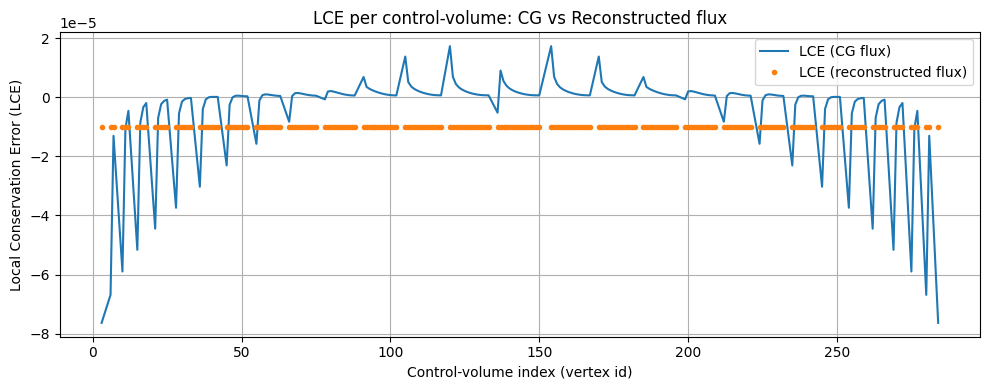

CG LCE stats: {'min': -7.63512929212156e-05, 'max': 1.7238891868794678e-05, 'L1_mean_abs': 5.636899886609056e-06, 'L2_rms': 1.4283769556540374e-05}
Reconstructed LCE stats: {'min': -1.0172526041898541e-05, 'max': -1.0172526041480473e-05, 'L1_mean_abs': 1.0172526041667146e-05, 'L2_rms': 1.0172526041667146e-05}


In [10]:
#only interior
import matplotlib.pyplot as plt
# geometry + local cell vertices
# geometry = mesh.geometry.x.copy()
# local_cell_vertices = dolfinx_cells(mesh)
num_local_cells = local_cell_vertices.shape[0]

# map vertex -> adjacent local cells
vertex_to_cells = {}
for local_cell_idx, verts in enumerate(local_cell_vertices):
    for v in verts:
        vertex_to_cells.setdefault(int(v), []).append(int(local_cell_idx))

# compute element-wise gradients (P1)
dofmap = V.dofmap

# compute LCEs per vertex (control-volume)
vertex_ids = sorted(list(vertex_to_cells.keys()))
LCE_CG = []
LCE_rec = []
indices = []

for vid in tqdm(vertex_ids):
    flux_sum_CG = 0.0
    flux_sum_rec = 0.0
    source_sum = 0.0
    adjacent_cells = vertex_to_cells[vid]
    vertex_coord = omega_geometry[vid]
    if len(adjacent_cells) == 6:
        for local_cell_idx in adjacent_cells:
            verts = local_cell_vertices[local_cell_idx]
            local_idx = int(list(verts).index(vid))
            coords = omega_geometry[verts]
            centroid = cell_centroid(coords)
            edge_midpoints = [edge_midpoint(coords[i], coords[(i+1)%3]) for i in range(3)]
            midA = edge_midpoints[local_idx]
            midB = edge_midpoints[(local_idx-1) % 3]
            segs = [(centroid, midA), (centroid, midB)]

            grad_u = elem_grad_u[int(local_cell_idx)]
            # kappa_cent = elem_kappa_cent[int(local_cell_idx)]
            q_CG = - grad_u

            if int(local_cell_idx) in local_fluxes:
                q_rec = - local_fluxes[int(local_cell_idx)]["grad"]
            else:
                q_rec = q_CG

            for a, b in segs:
                seg_len = edge_length(a, b)
                t = b - a
                n = np.array([t[1], -t[0]])
                n_norm = np.linalg.norm(n)
                if n_norm == 0:
                    continue
                n_unit = n / n_norm
                k_at_tips = [eval_scalar_at_point(k_m,a), eval_scalar_at_point(k_m,b)]
                # ensure normal points from centroid into the vertex side
                if np.dot(n_unit, (vertex_coord - a)) > 0:
                    n_unit = -n_unit
                flux_sum_CG += np.dot(q_CG, n_unit) * seg_len * np.sum(k_at_tips)/2
                flux_sum_rec += np.dot(q_rec, n_unit) * seg_len * np.sum(k_at_tips)/2

            if f is not None:
                vv = [coords[local_idx], midA, midB, centroid]
                hf = [eval_scalar_at_point(f, v_pol) for v_pol in vv]
                source_sum += polygon_volume(vv, hf, [[0,1,2],[1,2,3]])
                # fval = eval_scalar_at_point(f, centroid)
                # source_sum += fval * (elem_area[int(local_cell_idx)] / 3.0)

        LCE_CG.append(flux_sum_CG - source_sum)
        LCE_rec.append(flux_sum_rec - source_sum)
        indices.append(vid)

indices = np.array(indices, dtype=int)
LCE_CG = np.array(LCE_CG, dtype=float)
LCE_rec = np.array(LCE_rec, dtype=float)

# plot
plt.figure(figsize=(10,4))
plt.plot(indices, LCE_CG, label="LCE (CG flux)")
plt.plot(indices, LCE_rec, ".", label="LCE (reconstructed flux)")
plt.xlabel("Control-volume index (vertex id)")
plt.ylabel("Local Conservation Error (LCE)")
plt.title("LCE per control-volume: CG vs Reconstructed flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
# out_path = "/mnt/data/lce_plot.png"
# plt.savefig(out_path)
plt.show()

# print stats & produce dataframe
def stats(arr):
    return {"min": float(arr.min()), "max": float(arr.max()), "L1_mean_abs": float(np.mean(np.abs(arr))), "L2_rms": float(np.sqrt(np.mean(arr**2)))}
print("CG LCE stats:", stats(LCE_CG))
print("Reconstructed LCE stats:", stats(LCE_rec))

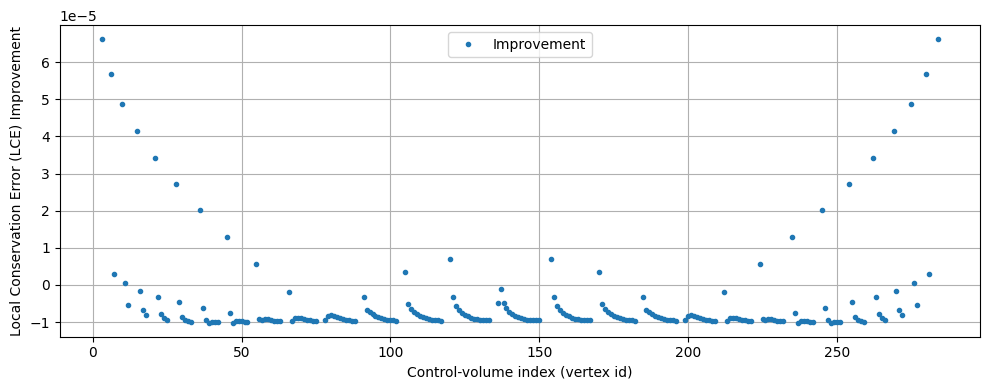

In [11]:
#plot improvement
plt.figure(figsize=(10,4))
plt.plot(indices, np.abs(LCE_CG)-np.abs(LCE_rec), ".", label="Improvement")
# plt.plot(indices, LCE_rec, ".", label="LCE (reconstructed flux)")
plt.xlabel("Control-volume index (vertex id)")
plt.ylabel("Local Conservation Error (LCE) Improvement")
# plt.title("LCE per control-volume: CG vs Reconstructed flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
# out_path = "/mnt/data/lce_plot.png"
# plt.savefig(out_path)
plt.show()

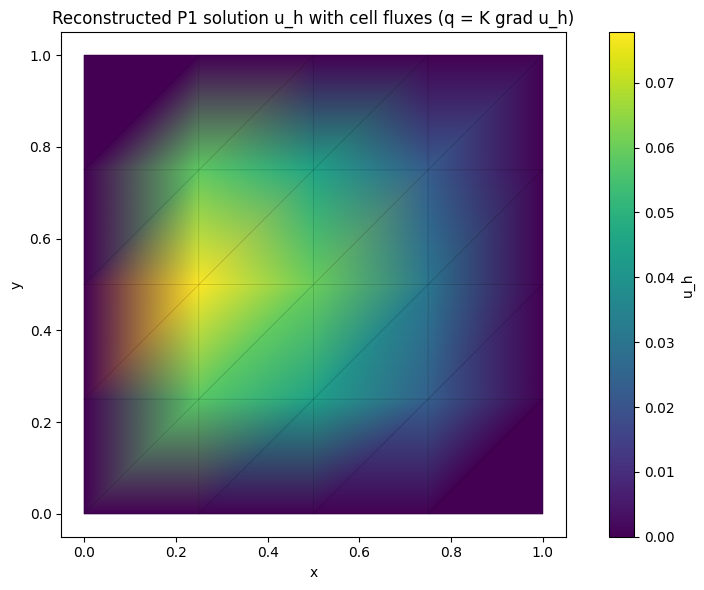

In [7]:
# 1) gather global vertex coordinates and accumulate nodal values
vertex_coords = {}   # global_vid -> (x,y)
vertex_sum = {}      # global_vid -> accumulated nodal value
vertex_count = {}    # global_vid -> number of contributions

for cell_id, data in local_fluxes.items():
    coeffs = np.asarray(data["coeffs"], dtype=float)
    cell_vertices = np.asarray(data["cell_vertices"], dtype=int)
    coords = data.get("cell_coords", None)
    if coords is not None:
        coords = np.asarray(coords, dtype=float)
        if coords.shape != (3, coords.shape[1]):
            coords = None  # fallback if shapes don't match

    for local_i, gv in enumerate(cell_vertices):
        gv = int(gv)
        if coords is not None:
            coord = coords[local_i]
        else:
            # if coord not provided yet, we will raise later if missing
            coord = vertex_coords.get(gv, None)

        if coord is None:
            # try to infer from any cell that provides coords for this vertex later;
            # for now store None placeholder and continue accumulating values
            pass
        else:
            vertex_coords[gv] = np.asarray(coord, dtype=float)

        vertex_sum[gv] = vertex_sum.get(gv, 0.0) + float(coeffs[local_i])
        vertex_count[gv] = vertex_count.get(gv, 0) + 1

# Ensure we have coords for every vertex seen; if not, attempt to fill from any cell_coords available
# for cell_id, data in local_fluxes.items():
#     coords = data.get("cell_coords", None)
#     if coords is None:
#         continue
#     coords = np.asarray(coords, dtype=float)
#     cell_vertices = np.asarray(data["cell_vertices"], dtype=int)
#     for local_i, gv in enumerate(cell_vertices):
#         gv = int(gv)
#         if gv not in vertex_coords or vertex_coords[gv] is None:
#             vertex_coords[gv] = coords[local_i]

# Check no missing coordinates remain
missing = [gv for gv, c in vertex_coords.items() if c is None]
if missing:
    raise RuntimeError(f"Missing coordinates for global vertices: {missing}. "
                       "Include 'cell_coords' for each cell or provide a global coordinate map.")

# 2) build contiguous indexing and point array for triangulation
global_vids = sorted(vertex_coords.keys())
vid_to_idx = {gv: i for i, gv in enumerate(global_vids)}
points = np.array([vertex_coords[gv] for gv in global_vids])  # (n_points, 2)

# 3) build triangle connectivity and collect per-cell centroids + fluxes
triangles = []
tri_centroids = []
tri_fluxes = []

for cell_id, data in local_fluxes.items():
    cell_vertices = np.asarray(data["cell_vertices"], dtype=int)
    coords = data.get("cell_coords", None)
    if coords is not None:
        coords = np.asarray(coords, dtype=float)
    q = np.asarray(data.get("q", [0.0, 0.0]), dtype=float)

    tri = [vid_to_idx[int(gv)] for gv in cell_vertices]
    triangles.append(tri)

    if coords is not None:
        tri_coords = coords
    else:
        tri_coords = points[tri]
    centroid = np.mean(tri_coords, axis=0)
    tri_centroids.append(centroid)
    tri_fluxes.append(q)

triangles = np.asarray(triangles, dtype=int)
tri_centroids = np.asarray(tri_centroids, dtype=float)
tri_fluxes = np.asarray(tri_fluxes, dtype=float)

# 4) compute nodal values by averaging contributions from cells
n_points = len(global_vids)
nodal_values = np.empty(n_points, dtype=float)
for i, gv in enumerate(global_vids):
    s = vertex_sum.get(gv, 0.0)
    c = vertex_count.get(gv, 1)
    nodal_values[i] = s / c

# 5) create matplotlib triangulation and plot
x = points[:, 0]
y = points[:, 1]
import matplotlib.tri as mtri
triang = mtri.Triangulation(x, y, triangles)

fig, ax = plt.subplots(figsize=(9, 6))

# piecewise-linear shading of nodal values
tpc = ax.tripcolor(triang, nodal_values, shading="gouraud")
fig.colorbar(tpc, ax=ax, label="u_h")

# optional: draw mesh edges lightly
ax.triplot(triang, color="k", linewidth=0.4, alpha=0.25)

# overlay per-cell flux vectors (q) at triangle centroids
# if tri_fluxes.size > 0:
#     # choose scale heuristically so arrows are visible
#     bbox = np.ptp(points, axis=0)            # domain size
#     qs = np.linalg.norm(tri_fluxes, axis=1)
#     max_q = qs.max() if qs.size else 1.0
#     if max_q == 0:
#         qscale = 1.0
#     else:
#         qscale = max(0.15 * np.linalg.norm(bbox) / max_q, 1e-8)

#     ax.quiver(tri_centroids[:,0], tri_centroids[:,1],
#               tri_fluxes[:,0], tri_fluxes[:,1],
#               angles='xy', scale_units='xy', scale=1.0/qscale, width=0.003, alpha=0.9)

ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Reconstructed P1 solution u_h with cell fluxes (q = K grad u_h)")
plt.tight_layout()

# show or save
plt.show()

In [13]:
coef_glob

{0: [np.float64(1.0), np.float64(1.0), np.float64(1.0)],
 1: [np.float64(1.9375), np.float64(1.9375000000000002), np.float64(1.9375)],
 2: [np.float64(1.0)],
 3: [np.float64(1.9374999999999993),
  np.float64(1.9374999999999996),
  np.float64(1.9374999999999996),
  np.float64(1.937499999999999),
  np.float64(1.937499999999999),
  np.float64(1.9375)],
 4: [np.float64(1.0), np.float64(1.0), np.float64(1.0)],
 5: [np.float64(2.874999999999999),
  np.float64(2.8750000000000004),
  np.float64(2.875000000000001)],
 6: [np.float64(1.9374999999999993),
  np.float64(1.9375),
  np.float64(1.9375),
  np.float64(1.9375000000000002),
  np.float64(1.9375000000000002),
  np.float64(1.9375)],
 7: [np.float64(2.8749999999999996),
  np.float64(2.874999999999999),
  np.float64(2.874999999999999),
  np.float64(2.875000000000001),
  np.float64(2.875000000000001),
  np.float64(2.874999999999998)],
 8: [np.float64(1.0), np.float64(1.0), np.float64(1.0)],
 9: [np.float64(3.8124999999999996),
  np.float64(3.812

In [80]:
omega.geometry.x

array([[0.  , 0.75, 0.  ],
       [0.25, 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.25, 0.75, 0.  ],
       [0.  , 0.5 , 0.  ],
       [0.5 , 1.  , 0.  ],
       [0.25, 0.5 , 0.  ],
       [0.5 , 0.75, 0.  ],
       [0.  , 0.25, 0.  ],
       [0.75, 1.  , 0.  ],
       [0.25, 0.25, 0.  ],
       [0.5 , 0.5 , 0.  ],
       [0.75, 0.75, 0.  ],
       [0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.  ],
       [0.25, 0.  , 0.  ],
       [0.5 , 0.25, 0.  ],
       [0.75, 0.5 , 0.  ],
       [1.  , 0.75, 0.  ],
       [0.5 , 0.  , 0.  ],
       [0.75, 0.25, 0.  ],
       [1.  , 0.5 , 0.  ],
       [0.75, 0.  , 0.  ],
       [1.  , 0.25, 0.  ],
       [1.  , 0.  , 0.  ]])